
# A/B Testing Project (Simulated Data) — Frequentist & Bayesian

This notebook demonstrates an end-to-end A/B test on **fake data** and ties back to core Probability & Statistics topics:

- **Distributions**: Bernoulli/Binomial for conversions; Lognormal for revenue  
- **Bayes' theorem & conditional probability**: Beta–Bernoulli posterior; `P(p_B > p_A)`  
- **Hypothesis testing**: two-proportion **z-test**, **chi-square** test, **Welch’s t-test** for mean revenue  
- **p-values** and **confidence intervals** (Wald CI for proportions; Welch CI for mean diff; **Wilson** CI for safer proportions)  
- **Sampling theory**: large-sample normal approximation for proportions; Monte Carlo for Bayesian posteriors  
- **Power & Sample Size**: per-arm `n` for a target MDE and achievable MDE for fixed `n`  
- **DevOps add-ons**: deterministic seeds, container/CI friendliness, Streamlit UI generator


## Setup

In [135]:

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

np.random.seed(42)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


## 1) Simulate fake A/B data

In [136]:

# Sample sizes
N_A = 4000
N_B = 4000

# True conversion probabilities (Bernoulli); B has a modest lift
p_A = 0.08
p_B = 0.092

# Simulate binary conversions
conv_A = np.random.binomial(1, p_A, size=N_A)
conv_B = np.random.binomial(1, p_B, size=N_B)

# Continuous outcome (e.g., revenue) only for converters; use lognormal to mimic skew
rev_mu_A, rev_sigma_A = 1.8, 0.9
rev_mu_B, rev_sigma_B = 1.9, 0.9

revenue_A = np.where(conv_A == 1, np.random.lognormal(mean=rev_mu_A, sigma=rev_sigma_A, size=N_A), 0.0)
revenue_B = np.where(conv_B == 1, np.random.lognormal(mean=rev_mu_B, sigma=rev_sigma_B, size=N_B), 0.0)

# Assemble dataframe
df = pd.DataFrame({
    "group": np.repeat(["A","B"], [N_A, N_B]),
    "converted": np.concatenate([conv_A, conv_B]),
    "revenue": np.concatenate([revenue_A, revenue_B])
})
df.head()


,group,converted,revenue
0,A,0,0.000000
1,A,1,16.691801
2,A,0,0.000000
3,A,0,0.000000
4,A,0,0.000000


## 2) Descriptive statistics

In [137]:

def summarize(group: str):
    sub = df[df.group == group]
    n = len(sub)
    conv = sub["converted"].sum()
    cr = conv / n
    mean_rev = sub["revenue"].mean()
    return n, conv, cr, mean_rev

nA, xA, crA, mrA = summarize("A")
nB, xB, crB, mrB = summarize("B")

lift_abs = crB - crA
lift_rel = crB/crA - 1.0

summary = pd.DataFrame({
    "group": ["A","B"],
    "n": [nA, nB],
    "conversions": [xA, xB],
    "conversion_rate": [crA, crB],
    "avg_revenue_per_user": [mrA, mrB]
})
summary


,group,n,conversions,conversion_rate,avg_revenue_per_user
0,A,4000,318,0.079500,0.715881
1,B,4000,372,0.093000,0.954703


## 3) Frequentist hypothesis tests

In [138]:

# 3a) Two-proportion z-test (pooled SE)
p_pool = (xA + xB) / (nA + nB)
se_prop = np.sqrt(p_pool*(1-p_pool)*(1/nA + 1/nB))
z_stat = (crB - crA) / se_prop
p_val_z = 2 * (1 - stats.norm.cdf(abs(z_stat)))

# 95% Wald CI for difference in proportions
z_crit = stats.norm.ppf(0.975)
ci_diff_prop = ((crB-crA) - z_crit*se_prop, (crB-crA) + z_crit*se_prop)

# 3b) Chi-square test of independence on 2x2 table
contingency = np.array([[xA, nA - xA],
                        [xB, nB - xB]])
chi2, p_val_chi2, dof, exp = stats.chi2_contingency(contingency, correction=False)

# 3c) Welch's t-test for mean revenue (per user)
A_rev = df[df.group=="A"]["revenue"].to_numpy()
B_rev = df[df.group=="B"]["revenue"].to_numpy()
t_stat, p_val_t = stats.ttest_ind(B_rev, A_rev, equal_var=False)

# Welch CI for mean difference
mean_diff = B_rev.mean() - A_rev.mean()
s2A = A_rev.var(ddof=1)
s2B = B_rev.var(ddof=1)
se_mean_diff = np.sqrt(s2A/nA + s2B/nB)
df_welch = (s2A/nA + s2B/nB)**2 / ((s2A**2)/((nA**2)*(nA-1)) + (s2B**2)/((nB**2)*(nB-1)))
t_crit = stats.t.ppf(0.975, df=df_welch)
ci_mean_diff = (mean_diff - t_crit*se_mean_diff, mean_diff + t_crit*se_mean_diff)

frequentist = pd.DataFrame({
    "metric": ["diff_conversion (B-A)", "z_stat", "p_value_z", "chi2", "p_value_chi2", "mean_rev_diff (B-A)", "t_stat", "p_value_t"],
    "value": [lift_abs, z_stat, p_val_z, chi2, p_val_chi2, mean_diff, t_stat, p_val_t],
    "ci_low": [ci_diff_prop[0], None, None, None, None, ci_mean_diff[0], None, None],
    "ci_high": [ci_diff_prop[1], None, None, None, None, ci_mean_diff[1], None, None]
})
frequentist


,metric,value,ci_low,ci_high
0,diff_conversion (B-A),0.013500,0.001197,0.025803
1,z_stat,2.150580,NaN,NaN
2,p_value_z,0.031509,NaN,NaN
3,chi2,4.624993,NaN,NaN
4,p_value_chi2,0.031509,NaN,NaN
5,mean_rev_diff (B-A),0.238822,0.072044,0.405601
6,t_stat,2.807048,NaN,NaN
7,p_value_t,0.005012,NaN,NaN


## 4) Bayesian analysis for conversion (Beta–Bernoulli)

In [139]:

# Beta(1,1) prior (uniform)
alphaA, betaA = 1 + xA, 1 + (nA - xA)
alphaB, betaB = 1 + xB, 1 + (nB - xB)

# Monte Carlo samples from posterior
draws = 200_000
samples_A = np.random.beta(alphaA, betaA, size=draws)
samples_B = np.random.beta(alphaB, betaB, size=draws)

prob_B_better = np.mean(samples_B > samples_A)
lift_samples = samples_B - samples_A
post_ci = (np.percentile(lift_samples, 2.5), np.percentile(lift_samples, 97.5))
post_mean_lift = lift_samples.mean()

bayes = pd.DataFrame({
    "metric": ["P(p_B > p_A)", "posterior_mean_lift", "posterior_95%_CI_low", "posterior_95%_CI_high"],
    "value": [prob_B_better, post_mean_lift, post_ci[0], post_ci[1]]
})
bayes


,metric,value
0,P(p_B > p_A),0.984175
1,posterior_mean_lift,0.013485
2,posterior_95%_CI_low,0.001160
3,posterior_95%_CI_high,0.025843


## 5) Visualizations

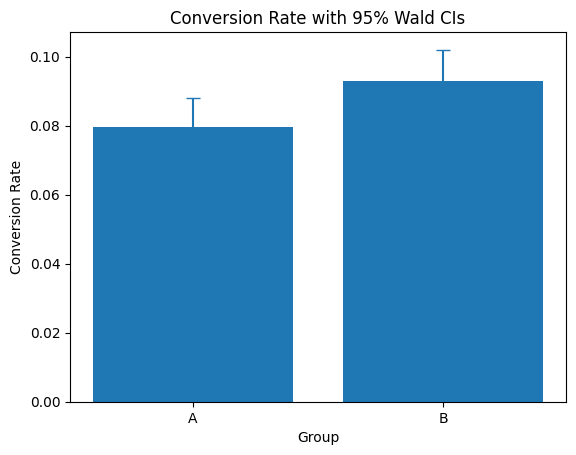

In [140]:

# Conversion rate bar chart with Wald CIs (matplotlib, single plot, no custom colors)
crs = [crA, crB]
ses = [np.sqrt(crA*(1-crA)/nA), np.sqrt(crB*(1-crB)/nB)]
cis_low = [crs[i] - z_crit*ses[i] for i in range(2)]
cis_high = [crs[i] + z_crit*ses[i] for i in range(2)]

x = np.arange(2)
plt.figure()
plt.bar(x, crs)
plt.errorbar(x, crs, yerr=[np.array(crs)-np.array(cis_low), np.array(cis_high)-np.array(crs)], fmt='none', capsize=5)
plt.xticks(x, ["A","B"])
plt.title("Conversion Rate with 95% Wald CIs")
plt.ylabel("Conversion Rate")
plt.xlabel("Group")
plt.show()


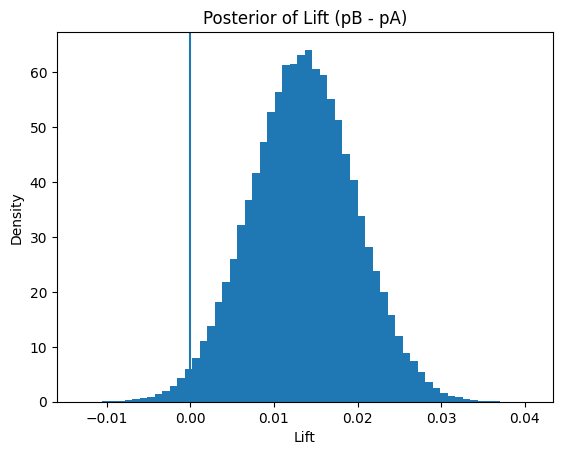

In [141]:

# Posterior distribution of lift (pB - pA)
plt.figure()
plt.hist(lift_samples, bins=60, density=True)
plt.axvline(0.0)
plt.title("Posterior of Lift (pB - pA)")
plt.xlabel("Lift")
plt.ylabel("Density")
plt.show()



## 6) Interpretation & Notes

- **Two-proportion z-test** assumes large-sample normality; for small samples or extreme rates, prefer **Wilson** or **exact** methods.  
- **Chi-square** agrees closely with the z-test for 2×2 tables.  
- **Welch’s t-test** is robust to unequal variances for the mean revenue comparison.  
- **Bayesian** summary directly answers *"What's the probability B is better?"* via `P(p_B > p_A)`.  
- Beware **peeking** (repeated looks at data) without proper sequential controls (alpha spending or Bayesian stopping).  
- Consider **power & sample size** before launching real experiments (minimum detectable effect, MDE).  


## 7) Utility: wrap into a reusable function

In [142]:

def run_ab(nA=4000, nB=4000, pA=0.08, pB=0.092, seed=42):
    import numpy as np
    from scipy import stats
    np.random.seed(seed)
    conv_A = np.random.binomial(1, pA, size=nA)
    conv_B = np.random.binomial(1, pB, size=nB)
    xA, xB = conv_A.sum(), conv_B.sum()
    crA, crB = xA/nA, xB/nB

    p_pool = (xA + xB) / (nA + nB)
    se = np.sqrt(p_pool*(1-p_pool)*(1/nA + 1/nB))
    z_stat = (crB - crA) / se
    p_val = 2*(1 - stats.norm.cdf(abs(z_stat)))
    z_crit = stats.norm.ppf(0.975)
    ci = ((crB-crA) - z_crit*se, (crB-crA) + z_crit*se)

    cont = np.array([[xA, nA-xA],[xB, nB-xB]])
    chi2, p_chi2, *_ = stats.chi2_contingency(cont, correction=False)
    return {
        "nA": nA, "nB": nB, "xA": xA, "xB": xB,
        "crA": crA, "crB": crB,
        "z_stat": z_stat, "p_value": p_val, "ci_low": ci[0], "ci_high": ci[1],
        "chi2": chi2, "p_chi2": p_chi2
    }

run_ab()


{'nA': 4000,
 'nB': 4000,
 'xA': np.int64(318),
 'xB': np.int64(372),
 'crA': np.float64(0.0795),
 'crB': np.float64(0.093),
 'z_stat': np.float64(2.1505795882219445),
 'p_value': np.float64(0.03150939786067952),
 'ci_low': np.float64(0.0011965661088753667),
 'ci_high': np.float64(0.02580343389112463),
 'chi2': np.float64(4.624992565276869),
 'p_chi2': np.float64(0.0315093978606795)}

## 8) Wilson score intervals for proportions

In [143]:

from math import sqrt
from scipy import stats

def wilson_ci(x: int, n: int, alpha: float = 0.05):
    if n == 0:
        return (float('nan'), float('nan'))
    z = stats.norm.ppf(1 - alpha/2)
    phat = x / n
    denom = 1 + z**2 / n
    center = (phat + z*z/(2*n)) / denom
    half_width = (z/denom) * sqrt((phat*(1-phat)/n) + (z*z/(4*n*n)))
    return center - half_width, center + half_width

wilson_A = wilson_ci(xA, nA)
wilson_B = wilson_ci(xB, nB)
pd.DataFrame({
    "group": ["A", "B"],
    "x": [xA, xB],
    "n": [nA, nB],
    "cr": [crA, crB],
    "wilson_low": [wilson_A[0], wilson_B[0]],
    "wilson_high": [wilson_A[1], wilson_B[1]],
})


,group,x,n,cr,wilson_low,wilson_high
0,A,318,4000,0.079500,0.071514,0.088292
1,B,372,4000,0.093000,0.084386,0.102395


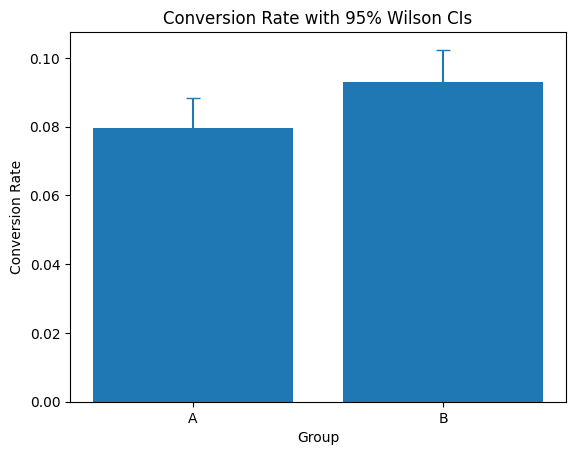

In [144]:

# Plot Wilson CIs vs point estimates
plt.figure()
points = [crA, crB]
wlow = [wilson_A[0], wilson_B[0]]
whigh = [wilson_A[1], wilson_B[1]]
x = np.arange(2)
plt.bar(x, points)
plt.errorbar(x, points, yerr=[np.array(points)-np.array(wlow), np.array(whigh)-np.array(points)], fmt='none', capsize=5)
plt.xticks(x, ['A','B'])
plt.title('Conversion Rate with 95% Wilson CIs')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.show()


## 9) Power & Sample Size (two-proportion z-test)

In [145]:

from scipy import stats
import numpy as np

def n_for_two_prop(p1, p2, alpha=0.05, power=0.8):
    # Normal approx, equal n per arm
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    pbar = 0.5*(p1 + p2); qbar = 1 - pbar
    var = p1*(1-p1) + p2*(1-p2)
    n = ((z_alpha*np.sqrt(2*pbar*qbar) + z_beta*np.sqrt(var))**2) / ((p2 - p1)**2)
    return int(np.ceil(n))

def required_n_for_mde(pA, mde_abs, alpha=0.05, power=0.8):
    pB = pA + mde_abs
    return n_for_two_prop(pA, pB, alpha=alpha, power=power)

def mde_for_n(pA, n, alpha=0.05, power=0.8):
    # Solve approximately by searching pB > pA that yields given n
    low, high = 1e-6, min(0.5, 0.9 - pA)  # absolute MDE bounds
    for _ in range(60):
        mid = 0.5*(low+high)
        n_req = required_n_for_mde(pA, mid, alpha, power)
        if n_req > n:
            low = mid
        else:
            high = mid
    return 0.5*(low+high)

# Example usage with current baseline
alpha=0.05
power=0.8
pA_baseline = crA  # use observed as proxy
target_mde_abs = 0.012  # detect +1.2pp

n_needed = required_n_for_mde(pA_baseline, target_mde_abs, alpha=alpha, power=power)
mde_given_n = mde_for_n(pA_baseline, nA, alpha=alpha, power=power)

pd.DataFrame({
    "alpha":[alpha],
    "power":[power],
    "baseline_cr":[pA_baseline],
    "target_MDE_abs":[target_mde_abs],
    "required_n_per_arm":[n_needed],
    "current_n_per_arm":[nA],
    "achievable_MDE_abs_with_current_n":[mde_given_n],
})


,alpha,power,baseline_cr,target_MDE_abs,required_n_per_arm,current_n_per_arm,achievable_MDE_abs_with_current_n
0,0.050000,0.800000,0.079500,0.012000,8523,4000,0.017780


In [147]:
from pathlib import Path

base = Path("/mnt/data/ab_test_project")
base.mkdir(parents=True, exist_ok=True)
app_path = base / "streamlit_app.py"

app_code = r"""
import numpy as np
import pandas as pd
from scipy import stats
import streamlit as st

st.title("A/B Testing Playground — Frequentist & Bayesian")
st.write("Simulate conversions and (optionally) revenue, then analyze.")

with st.sidebar:
    st.header("Simulation Settings")
    nA = st.number_input("nA", 100, 200000, 4000, 100)
    nB = st.number_input("nB", 100, 200000, 4000, 100)
    pA = st.number_input("pA (baseline)", 0.0001, 0.9999, 0.08, 0.0001, format="%.4f")
    lift = st.number_input("Absolute lift (pB - pA)", -0.2, 0.2, 0.012, 0.0001, format="%.4f")
    use_revenue = st.checkbox("Simulate revenue (lognormal)", value=True)
    seed = st.number_input("Random seed", 0, 10**6, 42, 1)
    alpha = st.number_input("alpha", 0.0001, 0.2, 0.05, 0.0001, format="%.4f")
    power = st.number_input("power (1-β)", 0.5, 0.9999, 0.8, 0.01, format="%.2f")

np.random.seed(seed)
pB = pA + lift

# Simulate conversions
conv_A = np.random.binomial(1, pA, size=int(nA))
conv_B = np.random.binomial(1, pB, size=int(nB))

if use_revenue:
    rev_mu_A, rev_sigma_A = 1.8, 0.9
    rev_mu_B, rev_sigma_B = 1.9, 0.9
    revenue_A = np.where(conv_A==1, np.random.lognormal(rev_mu_A, rev_sigma_A, int(nA)), 0.0)
    revenue_B = np.where(conv_B==1, np.random.lognormal(rev_mu_B, rev_sigma_B, int(nB)), 0.0)
else:
    revenue_A = np.zeros(int(nA))
    revenue_B = np.zeros(int(nB))

xA, xB = int(conv_A.sum()), int(conv_B.sum())
crA, crB = xA/nA, xB/nB

st.subheader("Summary")
st.write(pd.DataFrame({
    "group":["A","B"],
    "n":[nA,nB],
    "conversions":[xA, xB],
    "conversion_rate":[crA, crB],
    "avg_revenue_per_user":[revenue_A.mean(), revenue_B.mean()]
}))

# ---------- Frequentist ----------
p_pool = (xA + xB) / (nA + nB)
se = np.sqrt(p_pool*(1 - p_pool)*(1/nA + 1/nB)) if (nA>0 and nB>0) else np.nan
z = (crB - crA)/se if (se is not None and np.isfinite(se) and se>0) else np.nan
pval_z = 2*(1-stats.norm.cdf(abs(z))) if (se is not None and np.isfinite(se) and se>0) else np.nan
zcrit = stats.norm.ppf(0.975)
ci = ((crB-crA)-zcrit*se, (crB-crA)+zcrit*se) if (se is not None and np.isfinite(se) and se>0) else (np.nan, np.nan)

table = np.array([[xA, nA-xA],[xB, nB-xB]])
chi2, p_chi2, *_ = stats.chi2_contingency(table, correction=False)

# Wilson CI helper
def wilson_ci(x, n, alpha=0.05):
    if n==0: return (np.nan, np.nan)
    z = stats.norm.ppf(1 - alpha/2)
    phat = x/n
    denom = 1 + z**2/n
    center = (phat + z*z/(2*n))/denom
    half = (z/denom)*np.sqrt((phat*(1-phat)/n) + (z*z/(4*n*n)))
    return center-half, center+half

wilson_A = wilson_ci(xA, nA, alpha)
wilson_B = wilson_ci(xB, nB, alpha)

st.subheader("Frequentist Tests")
rows = [
    {"metric":"diff (B-A) conv", "value": crB-crA, "ci_low": ci[0], "ci_high": ci[1]},
    {"metric":"z_stat",          "value": z,       "ci_low": None,   "ci_high": None},
    {"metric":"p_value_z",       "value": pval_z,  "ci_low": None,   "ci_high": None},
    {"metric":"chi2",            "value": chi2,    "ci_low": None,   "ci_high": None},
    {"metric":"p_value_chi2",    "value": p_chi2,  "ci_low": None,   "ci_high": None},
]
st.write(pd.DataFrame(rows))

# ---------- Revenue Welch t-test ----------
if use_revenue:
    t_stat, p_t = stats.ttest_ind(revenue_B, revenue_A, equal_var=False)
    s2A = revenue_A.var(ddof=1); s2B = revenue_B.var(ddof=1)
    se_mean = np.sqrt(s2A/nA + s2B/nB)
    df_w = (s2A/nA + s2B/nB)**2 / ((s2A**2)/((nA**2)*(nA-1)) + (s2B**2)/((nB**2)*(nB-1)))
    tcrit = stats.t.ppf(0.975, df=df_w)
    mean_diff = revenue_B.mean() - revenue_A.mean()
    ci_rev = (mean_diff - tcrit*se_mean, mean_diff + tcrit*se_mean)

    rows_rev = [
        {"metric":"mean_rev_diff (B-A)", "value": mean_diff, "ci_low": ci_rev[0], "ci_high": ci_rev[1]},
        {"metric":"t_stat",              "value": t_stat,    "ci_low": None,      "ci_high": None},
        {"metric":"p_value_t",           "value": p_t,       "ci_low": None,      "ci_high": None},
    ]
    st.write(pd.DataFrame(rows_rev))

# ---------- Bayesian ----------
draws = 100000
aA, bA = 1 + xA, 1 + (nA-xA)
aB, bB = 1 + xB, 1 + (nB-xB)
sA = np.random.beta(aA, bA, size=draws)
sB = np.random.beta(aB, bB, size=draws)
prob = (sB > sA).mean()
lift = (sB - sA)

st.subheader("Bayesian")
st.write(pd.DataFrame([{
    "metric":"P(p_B > p_A)",
    "value":prob,
    "ci_low": np.percentile(lift, 2.5),
    "ci_high":np.percentile(lift, 97.5)
}, {
    "metric":"posterior_mean_lift",
    "value":lift.mean(),
    "ci_low": None,
    "ci_high":None
}]))

# ---------- Power/MDE ----------
def n_for_two_prop(p1, p2, alpha=0.05, power=0.8):
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta = stats.norm.ppf(power)
    pbar = 0.5*(p1 + p2); qbar = 1 - pbar
    var = p1*(1-p1) + p2*(1-p2)
    n = ((z_alpha*np.sqrt(2*pbar*qbar) + z_beta*np.sqrt(var))**2) / ((p2 - p1)**2)
    return int(np.ceil(n))

def required_n_for_mde(pA, mde_abs, alpha=0.05, power=0.8):
    return n_for_two_prop(pA, pA + mde_abs, alpha, power)

def mde_for_n(pA, n, alpha=0.05, power=0.8):
    low, high = 1e-6, min(0.5, 0.9-pA)
    for _ in range(50):
        mid = 0.5*(low+high)
        if required_n_for_mde(pA, mid, alpha, power) > n:
            low = mid
        else:
            high = mid
    return 0.5*(low+high)

col1, col2 = st.columns(2)
with col1:
    target_mde = st.number_input("Target MDE (abs)", 0.0001, 0.5, 0.012, 0.0001, format="%.4f")
    st.write("Required n per arm:", required_n_for_mde(crA, target_mde, alpha, power))
with col2:
    st.write("Achievable MDE with current n:", mde_for_n(crA, nA, alpha, power))
"""

app_path.write_text(app_code, encoding="utf-8")
print(f"✅ Wrote fixed app to: {app_path}")



✅ Wrote fixed app to: /mnt/data/ab_test_project/streamlit_app.py


In [148]:
# Kill any old Streamlit processes
!pkill -f "streamlit run" || true

# Close existing ngrok tunnels and kill the agent
from pyngrok import ngrok
for t in ngrok.get_tunnels():
    try: ngrok.disconnect(t.public_url)
    except Exception: pass
ngrok.kill()
print("✅ Clean slate")


^C
✅ Clean slate


In [149]:
# Make sure the app exists at this path
!ls -l /mnt/data/ab_test_project/streamlit_app.py

# Start server on 8501 (headless)
!streamlit run /mnt/data/ab_test_project/streamlit_app.py --server.headless true --server.port 8501 &> /tmp/streamlit.log &


-rw-r--r-- 1 root root 5565 Sep 24 04:22 /mnt/data/ab_test_project/streamlit_app.py


In [150]:
import time, socket

def wait_for_port(host="127.0.0.1", port=8501, timeout=60):
    t0 = time.time()
    while time.time() - t0 < timeout:
        try:
            with socket.create_connection((host, port), timeout=1):
                return True
        except OSError:
            time.sleep(0.5)
    return False

ok = wait_for_port(port=8501, timeout=90)
print("Streamlit listening:", ok)
if not ok:
    # Show recent logs to diagnose
    print("---- Streamlit log tail ----")
    !tail -n 80 /tmp/streamlit.log


Streamlit listening: True


In [151]:
from pyngrok import conf, ngrok

# If needed, set your token once per runtime:
# conf.get_default().auth_token = "YOUR_TOKEN_HERE"

# Open (or reuse) a single tunnel to 8501
existing = [t for t in ngrok.get_tunnels() if t.config.get("addr","").endswith(":8501")]
if existing:
    public_url = existing[0].public_url
else:
    public_url = ngrok.connect(8501, "http").public_url

print("🌐 Streamlit public URL:", public_url)


🌐 Streamlit public URL: https://gyroidally-preparatory-haley.ngrok-free.dev


In [ ]:
!ngrok config add-authtoken 337nZdf2RvGJ3F3itztdNc6kJrb_28Fy5pFanXo9AUo77xPRp


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%pip install pyngrok


In [ ]:
from pyngrok import conf
conf.get_default().auth_token = "337nZdf2RvGJ3F3itztdNc6kJrb_28Fy5pFanXo9AUo77xPRp"


In [ ]:
!streamlit run /mnt/data/ab_test_project/streamlit_app.py --server.headless true --server.port 8501 &




2025-09-24 02:59:01.605 Port 8501 is already in use


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
print("Your public Streamlit URL:", public_url)


Your public Streamlit URL: NgrokTunnel: "https://gyroidally-preparatory-haley.ngrok-free.dev" -> "http://localhost:8501"


## 10) One-click Streamlit UI


Run the cell below to generate a `streamlit_app.py` you can launch with:

```bash
pip install -r requirements.txt
pip install streamlit
streamlit run streamlit_app.py
```


In [ ]:

# Write Streamlit app to project folder
app_path = "/mnt/data/ab_test_project/streamlit_app.py"
with open(app_path, "w", encoding="utf-8") as f:
    f.write("\nimport numpy as np\nimport pandas as pd\nfrom scipy import stats\nimport streamlit as st\n\nst.title(\"A/B Testing Playground \u2014 Frequentist & Bayesian\")\nst.write(\"Simulate conversions and (optionally) revenue, then analyze.\")\n\nwith st.sidebar:\n    st.header(\"Simulation Settings\")\n    nA = st.number_input(\"nA\", 100, 200000, 4000, 100)\n    nB = st.number_input(\"nB\", 100, 200000, 4000, 100)\n    pA = st.number_input(\"pA (baseline)\", 0.0001, 0.9999, 0.08, 0.0001, format=\"%.4f\")\n    lift = st.number_input(\"Absolute lift (pB - pA)\", -0.2, 0.2, 0.012, 0.0001, format=\"%.4f\")\n    use_revenue = st.checkbox(\"Simulate revenue (lognormal)\", value=True)\n    seed = st.number_input(\"Random seed\", 0, 10**6, 42, 1)\n    alpha = st.number_input(\"alpha\", 0.0001, 0.2, 0.05, 0.0001, format=\"%.4f\")\n    power = st.number_input(\"power (1-\u03b2)\", 0.5, 0.9999, 0.8, 0.01, format=\"%.2f\")\n\nnp.random.seed(seed)\npB = pA + lift\n\n# Simulate conversions\nconv_A = np.random.binomial(1, pA, size=int(nA))\nconv_B = np.random.binomial(1, pB, size=int(nB))\n\nif use_revenue:\n    rev_mu_A, rev_sigma_A = 1.8, 0.9\n    rev_mu_B, rev_sigma_B = 1.9, 0.9\n    revenue_A = np.where(conv_A==1, np.random.lognormal(rev_mu_A, rev_sigma_A, int(nA)), 0.0)\n    revenue_B = np.where(conv_B==1, np.random.lognormal(rev_mu_B, rev_sigma_B, int(nB)), 0.0)\nelse:\n    revenue_A = np.zeros(int(nA))\n    revenue_B = np.zeros(int(nB))\n\nxA, xB = conv_A.sum(), conv_B.sum()\ncrA, crB = xA/nA, xB/nB\nst.subheader(\"Summary\")\nst.write(pd.DataFrame({\n    \"group\":[\"A\",\"B\"],\n    \"n\":[nA,nB],\n    \"conversions\":[int(xA), int(xB)],\n    \"conversion_rate\":[crA, crB],\n    \"avg_revenue_per_user\":[revenue_A.mean(), revenue_B.mean()]\n}))\n\n# Proportions z-test\np_pool = (xA + xB) / (nA + nB)\nse = np.sqrt(p_pool*(1-pool)*(1/nA + 1/nB)) if (nA>0 and nB>0) else np.nan\n# Fix typo: (1-p_pool)\nse = np.sqrt(p_pool*(1-p_pool)*(1/nA + 1/nB)) if (nA>0 and nB>0) else np.nan\nz = (crB - crA)/se if se and se>0 else np.nan\npval_z = 2*(1-stats.norm.cdf(abs(z))) if se and se>0 else np.nan\nzcrit = stats.norm.ppf(0.975)\nci = ((crB-crA)-zcrit*se, (crB-crA)+zcrit*se) if se and se>0 else (np.nan,np.nan)\n\n# Chi-square\ntable = np.array([[xA, nA-xA],[xB, nB-xB]])\nchi2, p_chi2, *_ = stats.chi2_contingency(table, correction=False)\n\n# Wilson\ndef wilson_ci(x, n, alpha=0.05):\n    if n==0: return (np.nan, np.nan)\n    z = stats.norm.ppf(1 - alpha/2)\n    phat = x/n\n    denom = 1 + z**2/n\n    center = (phat + z*z/(2*n))/denom\n    half = (z/denom)*np.sqrt((phat*(1-phat)/n) + (z*z/(4*n*n)))\n    return center-half, center+half\n\nwilson_A = wilson_ci(int(xA), int(nA), alpha)\nwilson_B = wilson_ci(int(xB), int(nB), alpha)\n\nst.subheader(\"Frequentist Tests\")\nst.write(pd.DataFrame({\n    \"metric\":[\"diff (B-A) conv\", \"z_stat\", \"p_value_z\", \"chi2\", \"p_value_chi2\"],\n    \"value\":[crB-crA, z, pval_z, chi2, p_chi2],\n    \"ci_low\":[ci[0], None, None, None, None],\n    \"ci_high\":[ci[1], None, None, None, None],\n}))\n\n# Revenue Welch t-test\nif use_revenue:\n    t_stat, p_t = stats.ttest_ind(revenue_B, revenue_A, equal_var=False)\n    s2A = revenue_A.var(ddof=1); s2B = revenue_B.var(ddof=1)\n    se_mean = np.sqrt(s2A/nA + s2B/nB)\n    df_w = (s2A/nA + s2B/nB)**2 / ((s2A**2)/((nA**2)*(nA-1)) + (s2B**2)/((nB**2)*(nB-1)))\n    tcrit = stats.t.ppf(0.975, df=df_w)\n    ci_rev = ( (revenue_B.mean()-revenue_A.mean()) - tcrit*se_mean,\n               (revenue_B.mean()-revenue_A.mean()) + tcrit*se_mean )\n    st.write(pd.DataFrame({\n        \"metric\":[\"mean_rev_diff (B-A)\", \"t_stat\", \"p_value_t\"],\n        \"value\":[revenue_B.mean()-revenue_A.mean(), t_stat, p_t],\n        \"ci_low\":[ci_rev[0], None,],\n        \"ci_high\":[ci_rev[1], None,],\n    }))\n\n# Bayesian Beta-Bernoulli\ndraws = 100000\naA, bA = 1 + xA, 1 + (nA-xA)\naB, bB = 1 + xB, 1 + (nB-xB)\nsA = np.random.beta(aA, bA, size=draws)\nsB = np.random.beta(aB, bB, size=draws)\nprob = (sB > sA).mean()\nlift = (sB - sA)\nst.subheader(\"Bayesian\")\nst.write(pd.DataFrame({\n    \"metric\":[\"P(p_B > p_A)\", \"posterior_mean_lift\", \"posterior_95%_CI_low\", \"posterior_95%_CI_high\"],\n    \"value\":[prob, lift.mean(), np.percentile(lift, 2.5), np.percentile(lift, 97.5)]\n}))\n\n# Power/MDE helpers\ndef n_for_two_prop(p1, p2, alpha=0.05, power=0.8):\n    z_alpha = stats.norm.ppf(1 - alpha/2)\n    z_beta = stats.norm.ppf(power)\n    pbar = 0.5*(p1 + p2); qbar = 1 - pbar\n    var = p1*(1-p1) + p2*(1-p2)\n    n = ((z_alpha*np.sqrt(2*pbar*qbar) + z_beta*np.sqrt(var))**2) / ((p2 - p1)**2)\n    return int(np.ceil(n))\n\ndef required_n_for_mde(pA, mde_abs, alpha=0.05, power=0.8):\n    return n_for_two_prop(pA, pA + mde_abs, alpha, power)\n\ndef mde_for_n(pA, n, alpha=0.05, power=0.8):\n    low, high = 1e-6, min(0.5, 0.9-pA)\n    for _ in range(50):\n        mid = 0.5*(low+high)\n        if required_n_for_mde(pA, mid, alpha, power) > n:\n            low = mid\n        else:\n            high = mid\n    return 0.5*(low+high)\n\ncol1, col2 = st.columns(2)\nwith col1:\n    target_mde = st.number_input(\"Target MDE (abs)\", 0.0001, 0.5, 0.012, 0.0001, format=\"%.4f\")\n    st.write(\"Required n per arm:\", required_n_for_mde(crA, target_mde, alpha, power))\nwith col2:\n    st.write(\"Achievable MDE with current n:\", mde_for_n(crA, nA, alpha, power))\n")
app_path


'/mnt/data/ab_test_project/streamlit_app.py'

In [152]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

drive_path = "/content/drive/MyDrive/ab_testing_project"
os.makedirs(drive_path, exist_ok=True)
print("Project folder:", drive_path)


Project folder: /content/drive/MyDrive/ab_testing_project


In [ ]:
!cp -r /mnt/data/ab_test_project/* /content/drive/MyDrive/ab_testing_project/
